# Preparations

In [1]:
import torch
import torchvision
import os.path

import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

from sklearn import manifold
from math import exp, sqrt
from torch.autograd import Variable
from my_dataset import MNIST_M
from my_dataset import ST_Dataset

%matplotlib inline
%load_ext skip_kernel_extension

In [2]:
import torch.utils.model_zoo as model_zoo

In [3]:
from data_loader import get_train_test_loader, get_office31_dataloader

In [4]:
use_gpu = torch.cuda.is_available()
print("use_gpu = " + str(use_gpu))

use_gpu = True


# Structure

Pretrained AlexNet, with a 256-dimensional bottleneck on top of $\texttt{fc7}$.

In [38]:
class AlexNet(nn.Module):

    def __init__(self):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 256),
            nn.ReLU(inplace=True)
        )
        self.label_classifier = nn.Sequential(
            nn.Linear(256, 31)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256 * 6 * 6)
        x = self.classifier(x)
        x = self.label_classifier(x)
        return x
    
    def load_pretrained_part(self, state_dict):
        own_state = self.state_dict()
        for name, param in state_dict.items():
            if name not in own_state:
                continue
            if isinstance(param, nn.Parameter):
                # backwards compatibility for serialized parameters
                param = param.data
            own_state[name].copy_(param)

In [42]:
cnn_amazon = AlexNet()

model_url = "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth"

cnn_amazon.load_pretrained_part(model_zoo.load_url(model_url))

for param in cnn_amazon.features.parameters():
    param.requires_grad = False

if (use_gpu):
    cnn_amazon.cuda()
print(cnn_amazon)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p=0.5)
    (4): Linear(in_features=4096, out_feature

In [5]:
def reset_seq(seq):
    for m in seq:
        if isinstance(m, nn.Conv2d):
            n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            m.weight.data.normal_(0, sqrt(2 / n))
            if m.bias is not None:
                m.bias.data.zero_()
        elif isinstance(m, nn.Linear):
            size = m.weight.size()
            fan_out = size[0] # number of rows
            fan_in = size[1] # number of columns
            m.weight.data.normal_(0, sqrt(2 / (fan_in + fan_out)))
            m.bias.data.zero_()
        elif hasattr(m, 'reset_parameters'):
            m.reset_parameters()

# Office Dataset

In [6]:
from data_loader import get_train_test_loader, get_office31_dataloader

In [8]:
trainloader_amazon, testloader_amazon = get_train_test_loader("amazon", batch_size=128, testing_size=0.1, img_size=(227, 227))

In [9]:
trainloader_webcam, testloader_webcam = get_train_test_loader("webcam", batch_size=128, testing_size=0.1, img_size=(227, 227))

len(amazon dataset)
2817

len(webcam dataset)
795

len(dslr dataset)
498

In [7]:
# this function takes the numpy input image with dim 3 x height x width
def convert_to_plt(input_image):
    input_image = input_image*np.asarray([0.229, 0.224, 0.225]) + np.asarray([0.485, 0.456, 0.406])
    return input_imagea

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The 51th image in the first 128 images in the training set:


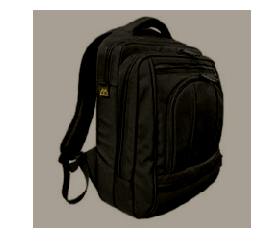

Its correspondent label:
tensor(0)


In [11]:
# randomly plot a sample from training set
import matplotlib.pyplot as plt

inputs = None
labels = None
for i, data in enumerate(trainloader_amazon):
    inputs, labels = data
    break

idx = np.random.randint(0, 128)
print("The " + str(idx) + "th image in the first 128" +\
      " images in the training set:")

plt_img = convert_to_plt(inputs[idx].permute(1, 2, 0).cpu().data.numpy())
plt.figure(figsize=(4,4))
plt.axis("off")
plt.imshow(plt_img)
plt.show()
print("Its correspondent label:\n" + str(labels[idx]))

## Training on AMAZON

Or you can load the parameters directly.

In [43]:
import os.path
para_file_amazon = "./parameters/cnn_amazon.pt"
if not os.path.exists('./parameters'):
    os.makedirs('./parameters')
load_model_amazon = os.path.isfile(para_file_amazon)
print("load_model = " + str(load_model_amazon))

load_model = True


In [44]:
%%skip (not $load_model_amazon)
cnn_amazon.load_state_dict(torch.load(para_file_amazon))

### Optimizer

In [14]:
import torch.optim as optim

lr_init = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(filter(lambda p: p.requires_grad, cnn_amazon.parameters()), lr=lr_init, momentum=0.9)

def adjust_lr(optimizer, p):
    global lr_init
    lr_0 = lr_init
    alpha = 10
    beta = 0.75
    lr = lr_0 / (1 + alpha * p) ** beta
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return lr

### Training process

In [15]:
%%skip $load_model_amazon

prev_loss = np.float("inf")
total_epoch = 40
finetune_epoch_start = 20
reset_seq(cnn_amazon.classifier)
reset_seq(cnn_amazon.label_classifier)

early_stop_cnt = 0

for epoch in range(total_epoch):
    epoch_loss = 0.0
    running_loss = 0.0
    p = epoch * 1.0 / total_epoch
    lr = adjust_lr(optimizer, p)
    if epoch == finetune_epoch_start:
        for param in cnn_amazon.features.parameters():
            param.requires_grad = True
            optimizer = optim.SGD(filter(lambda p: p.requires_grad, cnn_amazon.parameters()), lr=lr, momentum=0.9)
    for i, data in enumerate(trainloader_amazon):
        inputs, labels = data
        if (use_gpu):
            inputs, labels = inputs.cuda(), labels.cuda()
        inputs, labels = Variable(inputs), Variable(labels)
        optimizer.zero_grad()
        outputs = cnn_amazon(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        running_loss += loss.item()
        if i % 2 == 1:    # print every 50 mini-batches
            print('[%2d] batch loss: %.3f' %
                  (i + 1, running_loss / 2))
            running_loss = 0.0
    print("epoch %d loss: %.3f -> %.3f\n" % (epoch + 1, prev_loss, epoch_loss))
    if prev_loss - epoch_loss < 0.1:
        prev_loss = epoch_loss
        if epoch > finetune_epoch_start:
            early_stop_cnt += 1
            if early_stop_cnt > 2:
                break
    else:
        early_stop_cnt = 0
        prev_loss = epoch_loss

[ 2] batch loss: 6.789
[ 4] batch loss: 5.538
[ 6] batch loss: 4.146
[ 8] batch loss: 3.460
[10] batch loss: 3.387
[12] batch loss: 3.262
[14] batch loss: 3.153
[16] batch loss: 3.249
[18] batch loss: 3.154
[20] batch loss: 2.978
epoch 1 loss: inf -> 78.234

[ 2] batch loss: 2.901
[ 4] batch loss: 2.931
[ 6] batch loss: 2.620
[ 8] batch loss: 2.708
[10] batch loss: 2.471
[12] batch loss: 2.245
[14] batch loss: 2.216
[16] batch loss: 2.158
[18] batch loss: 2.287
[20] batch loss: 2.153
epoch 2 loss: 78.234 -> 49.380

[ 2] batch loss: 2.014
[ 4] batch loss: 1.925
[ 6] batch loss: 1.962
[ 8] batch loss: 1.823
[10] batch loss: 1.627
[12] batch loss: 1.808
[14] batch loss: 1.620
[16] batch loss: 1.799
[18] batch loss: 1.407
[20] batch loss: 1.778
epoch 3 loss: 49.380 -> 35.525

[ 2] batch loss: 1.603
[ 4] batch loss: 1.472
[ 6] batch loss: 1.452
[ 8] batch loss: 1.501
[10] batch loss: 1.471
[12] batch loss: 1.538
[14] batch loss: 1.397
[16] batch loss: 1.276
[18] batch loss: 1.247
[20] batch

[10] batch loss: 0.098
[12] batch loss: 0.219
[14] batch loss: 0.167
[16] batch loss: 0.146
[18] batch loss: 0.099
[20] batch loss: 0.093
epoch 32 loss: 3.146 -> 2.681

[ 2] batch loss: 0.144
[ 4] batch loss: 0.128
[ 6] batch loss: 0.208
[ 8] batch loss: 0.164
[10] batch loss: 0.125
[12] batch loss: 0.128
[14] batch loss: 0.124
[16] batch loss: 0.120
[18] batch loss: 0.120
[20] batch loss: 0.160
epoch 33 loss: 2.681 -> 2.843

[ 2] batch loss: 0.115
[ 4] batch loss: 0.153
[ 6] batch loss: 0.103
[ 8] batch loss: 0.106
[10] batch loss: 0.114
[12] batch loss: 0.108
[14] batch loss: 0.097
[16] batch loss: 0.090
[18] batch loss: 0.095
[20] batch loss: 0.092
epoch 34 loss: 2.843 -> 2.145

[ 2] batch loss: 0.146
[ 4] batch loss: 0.083
[ 6] batch loss: 0.102
[ 8] batch loss: 0.079
[10] batch loss: 0.114
[12] batch loss: 0.103
[14] batch loss: 0.099
[16] batch loss: 0.118
[18] batch loss: 0.121
[20] batch loss: 0.144
epoch 35 loss: 2.145 -> 2.218

[ 2] batch loss: 0.121
[ 4] batch loss: 0.114
[ 

In [16]:
%%skip $load_model_amazon

torch.save(cnn_amazon.state_dict(), para_file_amazon)

## Testing on AMAZON and WEBCAM

In [40]:
def evaluate_accuracy(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    for i, data in enumerate(dataloader):
        inputs, labels = data
        if (use_gpu):
            inputs, labels = inputs.cuda(), labels.cuda()
        with torch.no_grad():
            #inputs, labels = Variable(inputs, volatile=True), Variable(labels, volatile=True)
            inputs, labels = Variable(inputs), Variable(labels)
            outputs = model(inputs)
            correct += (torch.max(outputs.data, 1)[1] == labels.data).sum().item()
            total += labels.size()[0]
    acc = correct * 1.0 / total
    return acc

In [21]:
print("Accuracy on AMAZON test set (source only): " + str(evaluate_accuracy(cnn_amazon, testloader_amazon)))

Accuracy on AMAZON test set (source only): 0.8434163701067615


In [22]:
print("Accuracy on WEBCAM test set (source only): " + str(evaluate_accuracy(cnn_amazon, testloader_webcam)))

Accuracy on AMAZON test set (source only): 0.5063291139240507


AMAZON -> WEBCAM

Accuracy on AMAZON test set (source only): 0.8434163701067615

Accuracy on WEBCAM test set (source only): 0.5063291139240507

## Training on WEBCAM

In [23]:
cnn_webcam = AlexNet()

model_url = "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth"

cnn_webcam.load_pretrained_part(model_zoo.load_url(model_url))

for param in cnn_webcam.features.parameters():
    param.requires_grad = False

if (use_gpu):
    cnn_webcam.cuda()
print(cnn_webcam)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p=0.5)
    (4): Linear(in_features=4096, out_feature

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The 93th image in the first 128 images in the training set:


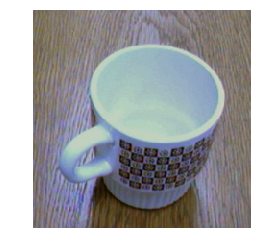

Its correspondent label:
tensor(17)


In [24]:
# randomly plot a sample from training set

inputs = None
labels = None
for i, data in enumerate(trainloader_webcam):
    inputs, labels = data
    break
    
idx = np.random.randint(0, 128)
print("The " + str(idx) + "th image in the first 128" +\
      " images in the training set:")

plt_img = convert_to_plt(inputs[idx].permute(1, 2, 0).cpu().data.numpy())
plt.figure(figsize=(4,4))
plt.axis("off")
plt.imshow(plt_img)
plt.show()
print("Its correspondent label:\n" + str(labels[idx]))

In [29]:
para_file_webcam = "./parameters/cnn_webcam.pt"
load_model_webcam = os.path.isfile(para_file_webcam)
print("load_model_webcam = " + str(load_model_webcam))

load_model_webcam = False


In [30]:
%%skip (not $load_model_webcam)
cnn_webcam.load_state_dict(torch.load(para_file_webcam))

In [31]:
import torch.optim as optim

lr_init = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(filter(lambda p: p.requires_grad, cnn_webcam.parameters()), lr=lr_init, momentum=0.9)

def adjust_lr(optimizer, p):
    global lr_init
    lr_0 = lr_init
    alpha = 10
    beta = 0.75
    lr = lr_0 / (1 + alpha * p) ** beta
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return lr

In [32]:
%%skip $load_model_webcam

prev_loss = np.float("inf")
total_epoch = 40
finetune_epoch_start = 20
reset_seq(cnn_webcam.classifier)
reset_seq(cnn_webcam.label_classifier)

early_stop_cnt = 0

for epoch in range(total_epoch):
    epoch_loss = 0.0
    running_loss = 0.0
    p = epoch * 1.0 / total_epoch
    lr = adjust_lr(optimizer, p)
    if epoch == finetune_epoch_start:
        for param in cnn_webcam.features.parameters():
            param.requires_grad = True
            optimizer = optim.SGD(filter(lambda p: p.requires_grad, cnn_webcam.parameters()), lr=lr, momentum=0.9)
    for i, data in enumerate(trainloader_webcam):
        inputs, labels = data
        if (use_gpu):
            inputs, labels = inputs.cuda(), labels.cuda()
        inputs, labels = Variable(inputs), Variable(labels)
        optimizer.zero_grad()
        outputs = cnn_webcam(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        running_loss += loss.item()
        if i % 2 == 1:    # print every 50 mini-batches
            print('[%2d] batch loss: %.3f' %
                  (i + 1, running_loss / 2))
            running_loss = 0.0
    print("epoch %d loss: %.3f -> %.3f\n" % (epoch + 1, prev_loss, epoch_loss))
    if prev_loss - epoch_loss < 0.1:
        prev_loss = epoch_loss
        if epoch > finetune_epoch_start:
            early_stop_cnt += 1
            if early_stop_cnt > 2:
                break
    else:
        early_stop_cnt = 0
        prev_loss = epoch_loss

[ 2] batch loss: 3.982
[ 4] batch loss: 3.317
[ 6] batch loss: 2.187
epoch 1 loss: inf -> 18.972

[ 2] batch loss: 1.175
[ 4] batch loss: 0.561
[ 6] batch loss: 0.408
epoch 2 loss: 18.972 -> 4.287

[ 2] batch loss: 0.186
[ 4] batch loss: 0.183
[ 6] batch loss: 0.088
epoch 3 loss: 4.287 -> 0.914

[ 2] batch loss: 0.049
[ 4] batch loss: 0.033
[ 6] batch loss: 0.039
epoch 4 loss: 0.914 -> 0.243

[ 2] batch loss: 0.012
[ 4] batch loss: 0.012
[ 6] batch loss: 0.021
epoch 5 loss: 0.243 -> 0.090

[ 2] batch loss: 0.004
[ 4] batch loss: 0.004
[ 6] batch loss: 0.005
epoch 6 loss: 0.090 -> 0.027

[ 2] batch loss: 0.003
[ 4] batch loss: 0.003
[ 6] batch loss: 0.002
epoch 7 loss: 0.027 -> 0.017

[ 2] batch loss: 0.002
[ 4] batch loss: 0.002
[ 6] batch loss: 0.002
epoch 8 loss: 0.017 -> 0.014

[ 2] batch loss: 0.002
[ 4] batch loss: 0.002
[ 6] batch loss: 0.002
epoch 9 loss: 0.014 -> 0.011

[ 2] batch loss: 0.001
[ 4] batch loss: 0.001
[ 6] batch loss: 0.002
epoch 10 loss: 0.011 -> 0.008

[ 2] batc

In [90]:
%%skip $load_model_webcam

torch.save(cnn_webcam.state_dict(), para_file_webcam)

In [33]:
print("Accuracy on WEBCAM test set (train on target): " + str(evaluate_accuracy(cnn_webcam, testloader_webcam)))

Accuracy on WEBCAM test set (train on target): 0.9746835443037974


AMAZON -> WEBCAM

Accuracy on WEBCAM test set (train on target): 0.9746835443037974

# Unsupervised Domain Adaptation

## Structure (GRL)

In [3]:
import torch
import torchvision
import os.path

import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

from sklearn import manifold
from math import exp, sqrt
from torch.autograd import Variable
from my_dataset import MNIST_M
from my_dataset import ST_Dataset

%matplotlib inline
%load_ext skip_kernel_extension

import torch.utils.model_zoo as model_zoo

from data_loader import get_train_test_loader, get_office31_dataloader

use_gpu = torch.cuda.is_available()
print("use_gpu = " + str(use_gpu))

def reset_seq(seq):
    for m in seq:
        if isinstance(m, nn.Conv2d):
            n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            m.weight.data.normal_(0, sqrt(2 / n))
            if m.bias is not None:
                m.bias.data.zero_()
        elif isinstance(m, nn.Linear):
            size = m.weight.size()
            fan_out = size[0] # number of rows
            fan_in = size[1] # number of columns
            m.weight.data.normal_(0, sqrt(2 / (fan_in + fan_out)))
            m.bias.data.zero_()
        elif hasattr(m, 'reset_parameters'):
            m.reset_parameters()
            
def evaluate_da_accuracy(model, dataloader, source):
    model.eval()
    correct_LC = 0
    correct_DC = 0
    total = 0
    
    with torch.no_grad():
        for i, data in enumerate(dataloader):
            inputs, labels = data
            if (use_gpu):
                inputs, labels = inputs.cuda(), labels.cuda()
            inputs, labels = Variable(inputs), Variable(labels)
            outputs_LC, outputs_DC = model(inputs)
            correct_LC += (torch.max(outputs_LC.data, 1)[1] == labels.data).sum().item()
            if source:
                correct_DC += labels.size()[0] - outputs_DC.data.sum().item()
            else:
                correct_DC += outputs_DC.data.sum().item()
            total += labels.size()[0]
        acc_LC = correct_LC / total
        acc_DC = correct_DC / total
    return acc_LC, acc_DC

use_gpu = True


In [4]:
trainloader_webcam = get_office31_dataloader("webcam", batch_size=28)

[INFO] Loading datasets: webcam


In [5]:
trainloader_amazon = get_office31_dataloader("amazon", batch_size=100)

[INFO] Loading datasets: amazon


In [6]:
# # randomly plot a sample from test set

# inputs = None
# labels = None
# for i, data in enumerate(trainloader_da):
#     inputs, labels, domain = data
#     if i == 2:
#         break

# idx = np.random.randint(0, batch_size)
# print("The " + str(idx) + "th image in the first " + str(batch_size) +\
#       " images in the training set:")
# plt_img = convert_to_plt(inputs[idx].permute(1, 2, 0).cpu().data.numpy())
# plt.figure(figsize=(1,1))
# plt.axis("off")
# plt.imshow(plt_img)
# plt.show()
# print("Its correspondent label:")
# if labels[idx].item() == -1:
#     print("I don't know :)\n")
# else:
#     print(str(labels[idx].item()) + "\n")

# print("From domain:")
# if domain[idx].item() == 0:
#     print("Source")
# else:
#     print("Target")

In [7]:
class GRL_func(torch.autograd.Function):

    @staticmethod
    def forward(ctx, inputs, lamda):
        ctx.save_for_backward(lamda)
        return inputs

    @staticmethod
    def backward(ctx, grad_outputs):
        lamda, = ctx.saved_tensors
        return -lamda * grad_outputs, None

In [8]:
class GRL(nn.Module):
    
    def __init__(self, lamda_init):
        super(GRL, self).__init__()
        self.GRL_func = GRL_func.apply
        self.lamda = nn.Parameter(torch.Tensor(1), requires_grad=False)
        self.set_lamda(lamda_init)
        
    def forward(self, x):
        return self.GRL_func(x, self.lamda)
    
    def set_lamda(self, lamda_new):
        self.lamda[0] = lamda_new

In [24]:
class AlexNet_DA(nn.Module):

    def __init__(self, lamda_init):
        super(AlexNet_DA, self).__init__()
        # lambda
        self.lamda = lamda_init
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 256),
            nn.ReLU(inplace=True)
        )
        self.label_classifier = nn.Sequential(
            nn.Linear(256, 31)
        )
        self.GRL_layer = GRL(lamda_init)
        self.domain_classifier = nn.Sequential(
            nn.Linear(256, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256 * 6 * 6)
        x = self.classifier(x)
        x_l = self.label_classifier(x)
        x_d = self.GRL_layer(x)
        x_d = self.domain_classifier(x_d)
        return x_l, x_d
    
    def set_lamda(self, lamda_new):
        self.GRL_layer.set_lamda(lamda_new)
    
    def load_pretrained_part(self, state_dict):
        own_state = self.state_dict()
        for name, param in state_dict.items():
            if name not in own_state:
                continue
            if isinstance(param, nn.Parameter):
                # backwards compatibility for serialized parameters
                param = param.data
            own_state[name].copy_(param)

In [25]:
cnn_da = AlexNet_DA(0)

cnn_da.load_pretrained_part(torch.load("./parameters/cnn_amazon.pt"))

if (use_gpu):
    cnn_da.cuda()
print(cnn_da)

AlexNet_DA(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p=0.5)
    (4): Linear(in_features=4096, out_feat

In [26]:
para_file_da = "./parameters/cnn_amazon_to_webcam.pt"
load_model_da = os.path.isfile(para_file_da)
print("load_model_da = " + str(load_model_da))

load_model_da = False


In [27]:
%%skip (not $load_model_da)
cnn_da.load_state_dict(torch.load(para_file_da))

### Optimizer

In [28]:
from math import exp

lr_init = 0.01
criterion_LC = nn.CrossEntropyLoss()
criterion_DC = nn.BCELoss()
optimizer = optim.SGD(filter(lambda p: p.requires_grad, cnn_da.parameters()), lr=lr_init, momentum=0.9)

def adjust_lr(optimizer, p):
    global lr_init
    lr_0 = lr_init
    alpha = 10
    beta = 0.75
    lr = lr_0 / (1 + alpha * p) ** beta
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return lr
        
def adjust_lamda(model, p):
    gamma = 10
    lamda = 2 / (1 + exp(- gamma * p)) - 1
    model.set_lamda(lamda)
    return lamda

In [29]:
print(("Label classifier accuracy on WEBCAM test set (DA): %f\n"
           "Domain classifier accuracy on WEBCAM test set (DA): %f\n")
          %evaluate_da_accuracy(cnn_da, trainloader_webcam, source=False))

Label classifier accuracy on WEBCAM test set (DA): 0.471939
Domain classifier accuracy on WEBCAM test set (DA): 0.485018



### Training process

In [30]:
#%%skip $load_model_da

prev_loss = np.float("inf")
prev_loss_LC = np.float("inf")
prev_loss_DC = np.float("inf")
total_epoch = 100
#reset_seq(cnn_da.domain_classifier)
acc_best = 0

for epoch in range(total_epoch):
    epoch_loss = 0.0
    running_loss = 0.0
    epoch_loss_LC = 0.0
    epoch_loss_DC = 0.0
    p = epoch * 1.0 / total_epoch
    adjust_lr(optimizer, p)
    lamda = adjust_lamda(cnn_da, p)
    
    i = 0
    iter_amazon = iter(trainloader_amazon)
    iter_webcam = iter(trainloader_webcam)
    while True:
        try:
            images_s, labels_s = iter_amazon.next()
            images_t, labels_t = iter_webcam.next() 
        except Exception:
            break
        source_size = labels_s.size(0)
        target_size = labels_t.size(0)
        inputs = torch.cat((images_s, images_t), dim=0)
        labels = torch.cat((labels_s, labels_t), dim=0)
        domains = torch.cat((torch.zeros(source_size), torch.ones(target_size)), dim=0)
        if (use_gpu):
            inputs, labels, domains = inputs.cuda(), labels.cuda(), domains.cuda()
        inputs, labels, domains = Variable(inputs), Variable(labels), Variable(domains)
        optimizer.zero_grad()
        # forward
        outputs_LC, outputs_DC = cnn_da(inputs)
        # compute loss
        outputs_DC = outputs_DC.view(-1)
        loss_LC = criterion_LC(outputs_LC[:source_size], labels[:source_size])
        loss_DC = criterion_DC(outputs_DC, domains)
        loss = loss_LC + loss_DC
        # backward
        loss.backward()
        optimizer.step()
        # stat
        epoch_loss += loss.item()
        running_loss += loss.item()
        epoch_loss_LC += loss_LC.item()
        epoch_loss_DC += loss_DC.item()
        if i % 5 == 4:    # print every 5 mini-batches
            print('[%2d] batch loss: %.3f' %
                  (i + 1, running_loss / 5))
            running_loss = 0.0
        i += 1
    print("epoch %d loss: %.3f -> %.3f" % (epoch + 1, prev_loss, epoch_loss))
    print("LC loss: %.3f -> %.3f" % (prev_loss_LC, epoch_loss_LC))
    print("DC loss: %.3f -> %.3f" % (prev_loss_DC, epoch_loss_DC))
    acc_l, acc_d = evaluate_da_accuracy(cnn_da, trainloader_webcam, source=False)
    print(("Label classifier accuracy on MNIST test set (DA): %f\n"
           "Domain classifier accuracy on MNIST test set (DA): %f\n")
          %(acc_l, acc_d))
    if acc_l > acc_best:
        acc_best = acc_l
        torch.save(cnn_da.state_dict(), "./parameters/cnn_amazon_to_webcam_best.pt")
    if prev_loss - epoch_loss < 0.1:
        prev_loss = epoch_loss
        prev_loss_LC = epoch_loss_LC
        prev_loss_DC = epoch_loss_DC
        pass
    else:
        prev_loss = epoch_loss
        prev_loss_LC = epoch_loss_LC
        prev_loss_DC = epoch_loss_DC

[ 5] batch loss: 0.708
[10] batch loss: 0.613
[15] batch loss: 0.587
[20] batch loss: 0.576
[25] batch loss: 0.544
epoch 1 loss: inf -> 16.871
LC loss: inf -> 3.838
DC loss: inf -> 13.033
Label classifier accuracy on MNIST test set (DA): 0.415816
Domain classifier accuracy on MNIST test set (DA): 0.278638

[ 5] batch loss: 0.484
[10] batch loss: 0.458
[15] batch loss: 0.429
[20] batch loss: 0.489
[25] batch loss: 0.459
epoch 2 loss: 16.871 -> 13.128
LC loss: 3.838 -> 2.474
DC loss: 13.033 -> 10.654
Label classifier accuracy on MNIST test set (DA): 0.433673
Domain classifier accuracy on MNIST test set (DA): 0.451824

[ 5] batch loss: 0.443
[10] batch loss: 0.454
[15] batch loss: 0.466
[20] batch loss: 0.472
[25] batch loss: 0.523
epoch 3 loss: 13.128 -> 13.161
LC loss: 2.474 -> 2.641
DC loss: 10.654 -> 10.520
Label classifier accuracy on MNIST test set (DA): 0.429847
Domain classifier accuracy on MNIST test set (DA): 0.321469

[ 5] batch loss: 0.422
[10] batch loss: 0.411
[15] batch los

[ 5] batch loss: 0.519
[10] batch loss: 0.505
[15] batch loss: 0.519
[20] batch loss: 0.521
[25] batch loss: 0.536
epoch 27 loss: 14.011 -> 14.592
LC loss: 0.069 -> 0.128
DC loss: 13.943 -> 14.464
Label classifier accuracy on MNIST test set (DA): 0.565051
Domain classifier accuracy on MNIST test set (DA): 0.254509

[ 5] batch loss: 0.536
[10] batch loss: 0.523
[15] batch loss: 0.521
[20] batch loss: 0.514
[25] batch loss: 0.509
epoch 28 loss: 14.592 -> 14.558
LC loss: 0.128 -> 0.090
DC loss: 14.464 -> 14.468
Label classifier accuracy on MNIST test set (DA): 0.545918
Domain classifier accuracy on MNIST test set (DA): 0.291923

[ 5] batch loss: 0.495
[10] batch loss: 0.489
[15] batch loss: 0.485
[20] batch loss: 0.531
[25] batch loss: 0.514
epoch 29 loss: 14.558 -> 14.088
LC loss: 0.090 -> 0.195
DC loss: 14.468 -> 13.893
Label classifier accuracy on MNIST test set (DA): 0.533163
Domain classifier accuracy on MNIST test set (DA): 0.273913

[ 5] batch loss: 0.506
[10] batch loss: 0.509
[15

[ 5] batch loss: 0.518
[10] batch loss: 0.514
[15] batch loss: 0.515
[20] batch loss: 0.525
[25] batch loss: 0.520
epoch 53 loss: 14.425 -> 14.522
LC loss: 0.026 -> 0.031
DC loss: 14.399 -> 14.491
Label classifier accuracy on MNIST test set (DA): 0.535714
Domain classifier accuracy on MNIST test set (DA): 0.237610

[ 5] batch loss: 0.515
[10] batch loss: 0.517
[15] batch loss: 0.510
[20] batch loss: 0.514
[25] batch loss: 0.522
epoch 54 loss: 14.522 -> 14.432
LC loss: 0.031 -> 0.031
DC loss: 14.491 -> 14.401
Label classifier accuracy on MNIST test set (DA): 0.529337
Domain classifier accuracy on MNIST test set (DA): 0.222049

[ 5] batch loss: 0.508
[10] batch loss: 0.521
[15] batch loss: 0.516
[20] batch loss: 0.528
[25] batch loss: 0.527
epoch 55 loss: 14.432 -> 14.576
LC loss: 0.031 -> 0.041
DC loss: 14.401 -> 14.535
Label classifier accuracy on MNIST test set (DA): 0.531888
Domain classifier accuracy on MNIST test set (DA): 0.223404

[ 5] batch loss: 0.514
[10] batch loss: 0.518
[15

[ 5] batch loss: 0.514
[10] batch loss: 0.515
[15] batch loss: 0.516
[20] batch loss: 0.525
[25] batch loss: 0.519
epoch 79 loss: 14.564 -> 14.513
LC loss: 0.023 -> 0.028
DC loss: 14.540 -> 14.485
Label classifier accuracy on MNIST test set (DA): 0.536990
Domain classifier accuracy on MNIST test set (DA): 0.230732

[ 5] batch loss: 0.519
[10] batch loss: 0.517
[15] batch loss: 0.518
[20] batch loss: 0.524
[25] batch loss: 0.523
epoch 80 loss: 14.513 -> 14.591
LC loss: 0.028 -> 0.029
DC loss: 14.485 -> 14.562
Label classifier accuracy on MNIST test set (DA): 0.531888
Domain classifier accuracy on MNIST test set (DA): 0.221996

[ 5] batch loss: 0.522
[10] batch loss: 0.522
[15] batch loss: 0.519
[20] batch loss: 0.524
[25] batch loss: 0.523
epoch 81 loss: 14.591 -> 14.618
LC loss: 0.029 -> 0.032
DC loss: 14.562 -> 14.586
Label classifier accuracy on MNIST test set (DA): 0.531888
Domain classifier accuracy on MNIST test set (DA): 0.227315

[ 5] batch loss: 0.515
[10] batch loss: 0.518
[15

In [31]:
acc_best

0.5650510204081632

In [94]:
%%skip $load_model_da

torch.save(cnn_da.state_dict(), para_file_da)

### Test on SVHN and MNIST dataset

In [17]:
def evaluate_da_accuracy(model, dataloader, source):
    model.eval()
    correct_LC = 0
    correct_DC = 0
    total = 0
    
    with torch.no_grad():
        for i, data in enumerate(dataloader):
            inputs, labels = data
            if (use_gpu):
                inputs, labels = inputs.cuda(), labels.cuda()
            inputs, labels = Variable(inputs), Variable(labels)
            outputs_LC, outputs_DC = model(inputs)
            correct_LC += (torch.max(outputs_LC.data, 1)[1] == labels.data).sum().item()
            if source:
                correct_DC += labels.size()[0] - outputs_DC.data.sum().item()
            else:
                correct_DC += outputs_DC.data.sum().item()
            total += labels.size()[0]
        acc_LC = correct_LC / total
        acc_DC = correct_DC / total
    return acc_LC, acc_DC

In [ ]:
cnn_new = AlexNet_DA(0)

cnn_new.load_state_dict(torch.load("./parameters/cnn_amazon_to_webca"))

if (use_gpu):
    cnn_da.cuda()
print(cnn_da)

In [35]:
print(("Label classifier accuracy on SVHN test set (DA): %f\n"
       "Domain classifier accuracy on SVHN test set (DA): %f")
      %evaluate_da_accuracy(cnn_da, testloader_svhn, source=True))

Label classifier accuracy on SVHN test set (DA): 0.919215
Domain classifier accuracy on SVHN test set (DA): 0.999045


In [36]:
print(("Label classifier accuracy on MNIST test set (DA): %f\n"
       "Domain classifier accuracy on MNIST test set (DA): %f")
      %evaluate_da_accuracy(cnn_da, testloader, source=False))

Label classifier accuracy on MNIST test set (DA): 0.697800
Domain classifier accuracy on MNIST test set (DA): 1.000000


### Visualization

In [95]:
f_svhn_da, lh_svhn_da, l_svhn_da = extract_features_da(cnn_da, testloader_svhn)
f_da, lh_da, l_da = extract_features_da(cnn_da, testloader)

Features of MNIST test set (extracted by DA model)

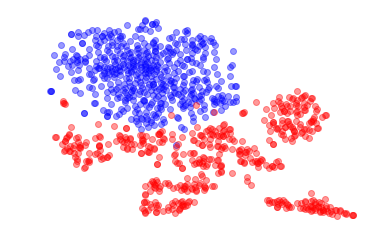

In [96]:
visualize_da(f_svhn_da.numpy(), f_da.numpy(), perplexity=50, sample_num=500,
             save="./pics/SVHN_to_MNIST_features_Adapted.svg")

Features of MNIST-M test set (extracted by DA model)

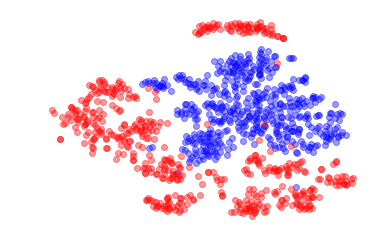

In [97]:
visualize_da(lh_svhn_da.numpy(), lh_da.numpy(), perplexity=50, sample_num=500,
             save="./pics/SVHN_to_MNIST_lasthidden_Adapted.svg")